In [1]:
import sys
import s3fs
import boto3
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn import preprocessing

INT_MAX = (2**32) - 1
le = preprocessing.LabelEncoder()
s3 = boto3.client('s3')
BUCKET = 'ioccino-data'

In [2]:
def df_to_s3(df):
    bytes_to_write = df.to_csv(None).encode()
    fs = s3fs.S3FileSystem()
    with fs.open('s3://' + BUCKET + '/data/coffee-flavors-'+ get_str_date() +'.csv', 'wb') as f:
        f.write(bytes_to_write)

In [3]:
def normalize_df(df):
    for c in df.columns.values:
        if c != 'target' and c != 'gender':
            x_array = np.array(df[c])
            df[c] = preprocessing.normalize([x_array])[0]
    return df

In [4]:
def get_str_date():
    return str(datetime.now()).replace(' ', '_')

In [5]:
def str_label_into_numbers(df):
    # Converting string labels into numbers.
    df['gender'] = le.fit_transform(df['gender'])
    df['state'] = le.fit_transform(df['state'])
    df['temperature'] = le.fit_transform(df['temperature'])
    df['feel'] = le.fit_transform(df['feel'])
    df['target'] = le.fit_transform(df['target'])
    return df

In [16]:
def main():
    try:
        df = pd.read_csv('s3://' + BUCKET + '/raw-data/coffee-flavors.csv')
        df.columns = ['timestamp', 'age', 'gender', 'state', 'temperature', 'feel', 'target']
        df['timestamp'] = pd.to_datetime(df['timestamp']).astype('int64') // 10**9
        
        df['target'] = df['target'].apply(lambda x: x.split(' ')[0]).copy()
        df = df[df.target != 'Não']
        df = df[df.target != 'AMENO']
        
        df = str_label_into_numbers(df)
        df = normalize_df(df)
        df_to_s3(df)
        ret = df
    except Exception as e:
        print('erro:', e)
        ret = None
    return ret

In [17]:
df = main()

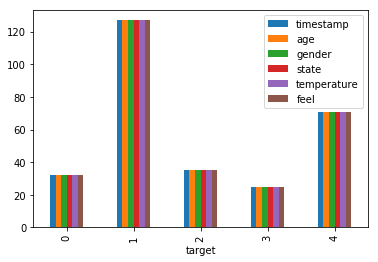

In [18]:
df.groupby(['target']).count().plot(kind='bar')